# Simple Claude-generated Flow Matching Notebook

The NN vector field tries to match a 2D Gaussian Mixture with a Flow Matching objective

In [1]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np

# Define a simple target distribution (2D Gaussian mixture)
def target_distribution(n_samples):
    mixture_weights = [0.5, 0.5]
    means = [[-2.0, -2.0], [2.0, 2.0]]
    covs = [[[1.0, 0.0], [0.0, 1.0]], [[1.0, 0.0], [0.0, 1.0]]]

    idx = np.random.choice(len(mixture_weights), size=n_samples, p=mixture_weights)
    samples = np.array([np.random.multivariate_normal(means[i], covs[i]) for i in idx])
    return torch.FloatTensor(samples)

In [2]:
# Define the neural network for velocity field
class VelocityNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(3, 64),  # Input: (x, y, t)
            nn.ReLU(),
            nn.Linear(64, 64),
            nn.ReLU(),
            nn.Linear(64, 2)   # Output: (v_x, v_y)
        )

    def forward(self, x, t):
        # Concatenate spatial coordinates and time
        xt = torch.cat([x, t.expand(x.shape[0], 1)], dim=1)
        return self.net(xt)

# Flow Matching training loop
def train_flow_matching(n_steps=1000, batch_size=128):
    velocity_net = VelocityNet()
    optimizer = torch.optim.Adam(velocity_net.parameters(), lr=1e-3)

    for step in range(n_steps):
        # Sample from standard normal (initial distribution)
        x0 = torch.randn(batch_size, 2)

        # Sample target distribution
        x1 = target_distribution(batch_size)

        # Sample random time points
        t = torch.rand(batch_size, 1)

        # Interpolate between initial and target points
        xt = x0 * (1 - t) + x1 * t

        # Get the ground truth velocity field
        v_t = x1 - x0  # Constant velocity field

        # Predict velocity using the network
        v_pred = velocity_net(xt, t)

        # Compute loss (L2 distance between predicted and true velocities)
        loss = torch.mean(torch.sum((v_pred - v_t) ** 2, dim=1))

        # Optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if step % 100 == 0:
            print(f"Step {step}, Loss: {loss.item():.4f}")

    return velocity_net

# Training and visualization code
velocity_net = train_flow_matching()

Step 0, Loss: 12.3439
Step 100, Loss: 8.4346
Step 200, Loss: 6.7934
Step 300, Loss: 5.9076
Step 400, Loss: 5.8042
Step 500, Loss: 7.6200
Step 600, Loss: 5.9623
Step 700, Loss: 6.9927
Step 800, Loss: 7.1790
Step 900, Loss: 6.8677


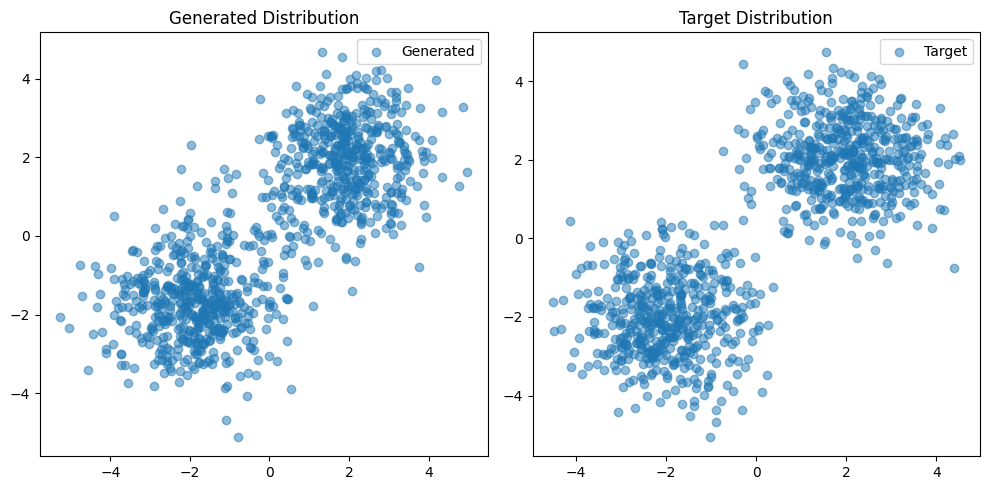

In [3]:
# Function to generate samples using trained model
def generate_samples(velocity_net, n_samples=1000, n_steps=50):
    x = torch.randn(n_samples, 2)  # Initial samples
    dt = 1.0 / n_steps

    with torch.no_grad():
        for i in range(n_steps):
            t = torch.ones(n_samples, 1) * i * dt
            v = velocity_net(x, t)
            x = x + v * dt

    return x

# Generate samples and visualize
samples = generate_samples(velocity_net)
target_samples = target_distribution(1000)

plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.scatter(samples[:, 0].numpy(), samples[:, 1].numpy(), alpha=0.5, label='Generated')
plt.title('Generated Distribution')
plt.legend()

plt.subplot(1, 2, 2)
plt.scatter(target_samples[:, 0].numpy(), target_samples[:, 1].numpy(), alpha=0.5, label='Target')
plt.title('Target Distribution')
plt.legend()

plt.tight_layout()
plt.show()